In [ ]:
"""
Grupo 23 - TP1 - Algebra Lineal Computacional - 2025

Integrantes:
Sofía Gerpe Lizárraga 411/23
Agustin Russo 39/23
Juan Pablo Anachure 99/16
"""

# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd # Para hacer cosas geográficas
import networkx as nx # Construcción de la red en NetworkX

from template_funciones import calculaLU, calcula_matriz_C, calcula_matriz_C_continua, calcula_B, calcula_pagerank, calcular_inversa, construye_adyacencia, graficar_red, graficar_red_periferia, graficar_nodos, resolver_sistema

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [7]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

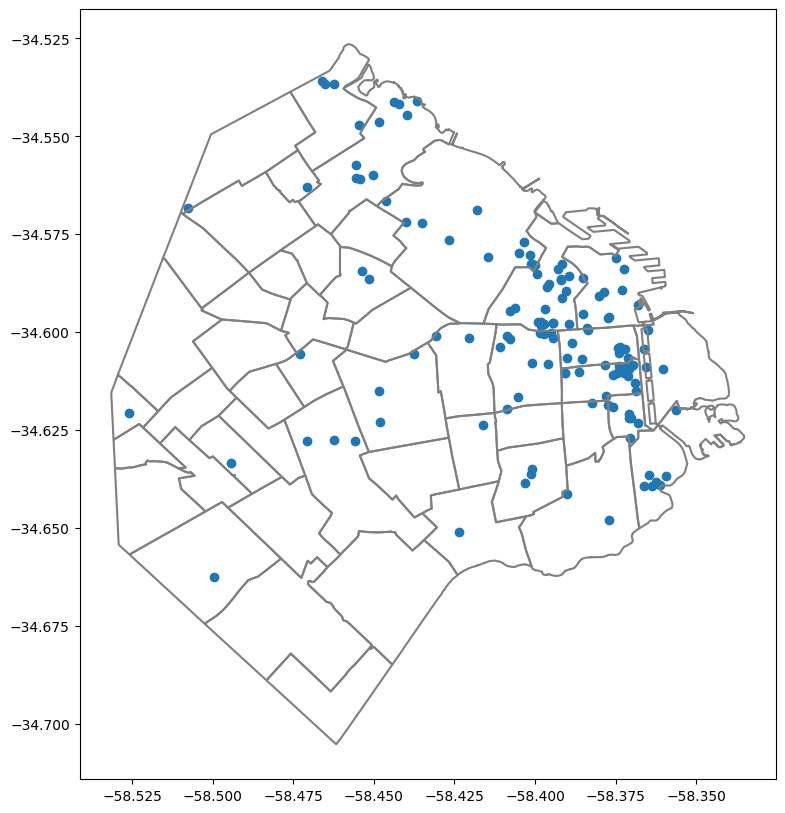

In [8]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [9]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [10]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [11]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

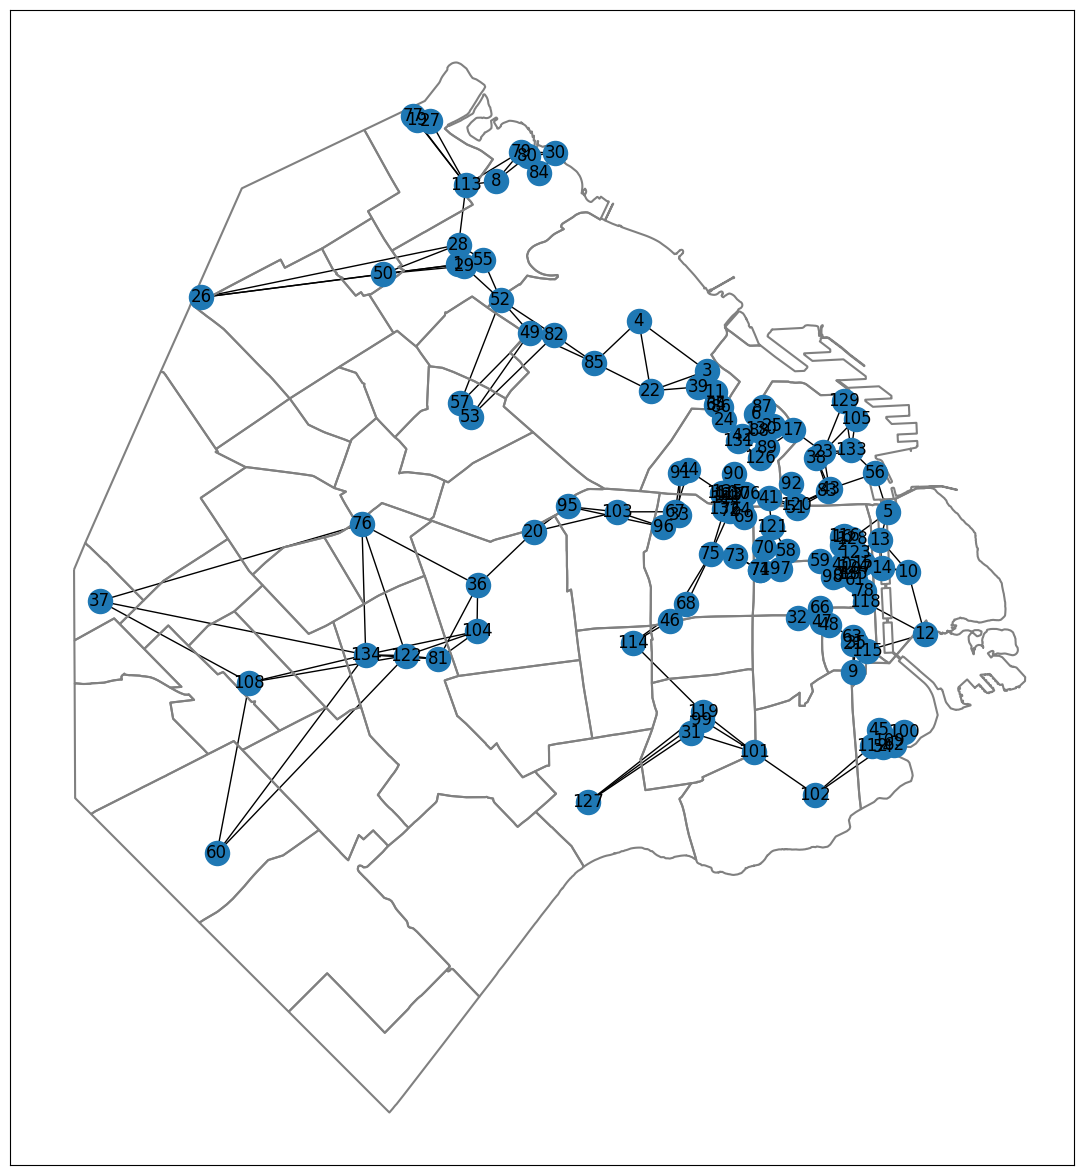

In [12]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

La ecuacion 3 define que:
$$ 
\bold{p} = (1 - \alpha)C \bold{p} + \frac{\alpha}{N} \bold{1} 
$$

Queremos demostrar que $M \bold{p} = \bold{b}$ con $M= \frac{N}{\alpha}(I - (1 - \alpha)C) $ y $\bold{b} = 1$

Podemos entonce manipular la ecuacion tres para conseguir que:
$$ \begin{align*}
\bold{p} &= (1 - \alpha)C \bold{p} + \frac{\alpha}{N} \bold{1} \\
\\
\bold{p} - (1 - \alpha)C \bold{p} &= \frac{\alpha}{N} \bold{1} \\
\\
(I - (1-\alpha)C)\bold{p} &= \frac{\alpha}{N} \bold{1} \\

\underbrace{\frac{N}{\alpha}(I - (1 - \alpha) C )}_{M} \bold{p} &= \bold{1} \\
M \bold{p} &= \bold{b}
\end{align*}
$$

## Punto 2:


a) El unico requerimiento es que la matrix M sea inversible

Partiendo de que $||B||_1 < 1$ queremos ver que $(I-B)$ es inversible

Vamos a demostrarlo por el absurdo:

Asumimos entonces $(I-B)$ no inversible

Por lo tanto $\exist x \neq 0 / (I-B)x = 0 $

$$
\begin{align*}
(I-B)x &= 0 \\
Ix-Bx &= 0 \\
Ix &= Bx \\
||Ix||_1 &= ||Bx||_1 \\
\end{align*}
$$

Sabemos que $||Ix||_1 = ||x||_1$, entonces:

$$
\begin{align*}
||x||_1 &= ||Bx||_1 \\
||x||_1 &= ||Bx||_1 <= ||B||_1 ||x||_1\\
\underbrace{\frac{||x||_1}{||x||_1}}_{=1} &<= \underbrace{||B||_1< 1}_{\text{Dato}} \\
1 &<= ||B||_1 < 1
\end{align*}
$$
**ABSURDO!**

Que vino de suponer que $(I-B)$ no era inversible

$\blacksquare$

---
b) A partir de la demostracion anterior lo que debe cumplirse para que M sea inversible dado $0<\alpha<1$ es que valga que $||(1-\alpha)C||_1 < 1$

Se puede ver que al ser C una matriz **estocastica** (sus columnas suman 1) $\rightarrow ||C||_1 = 1$

Entonces:
$$||(1-\alpha)C||_1 = (1-\alpha) \underbrace{||C||_1}_{=1} = (1 - \alpha) < 1$$

Como $0<\alpha<1$ se cumple las condiciones para que M sea inversible



## Punto 3:

NameError: name 'graficar_red' is not defined

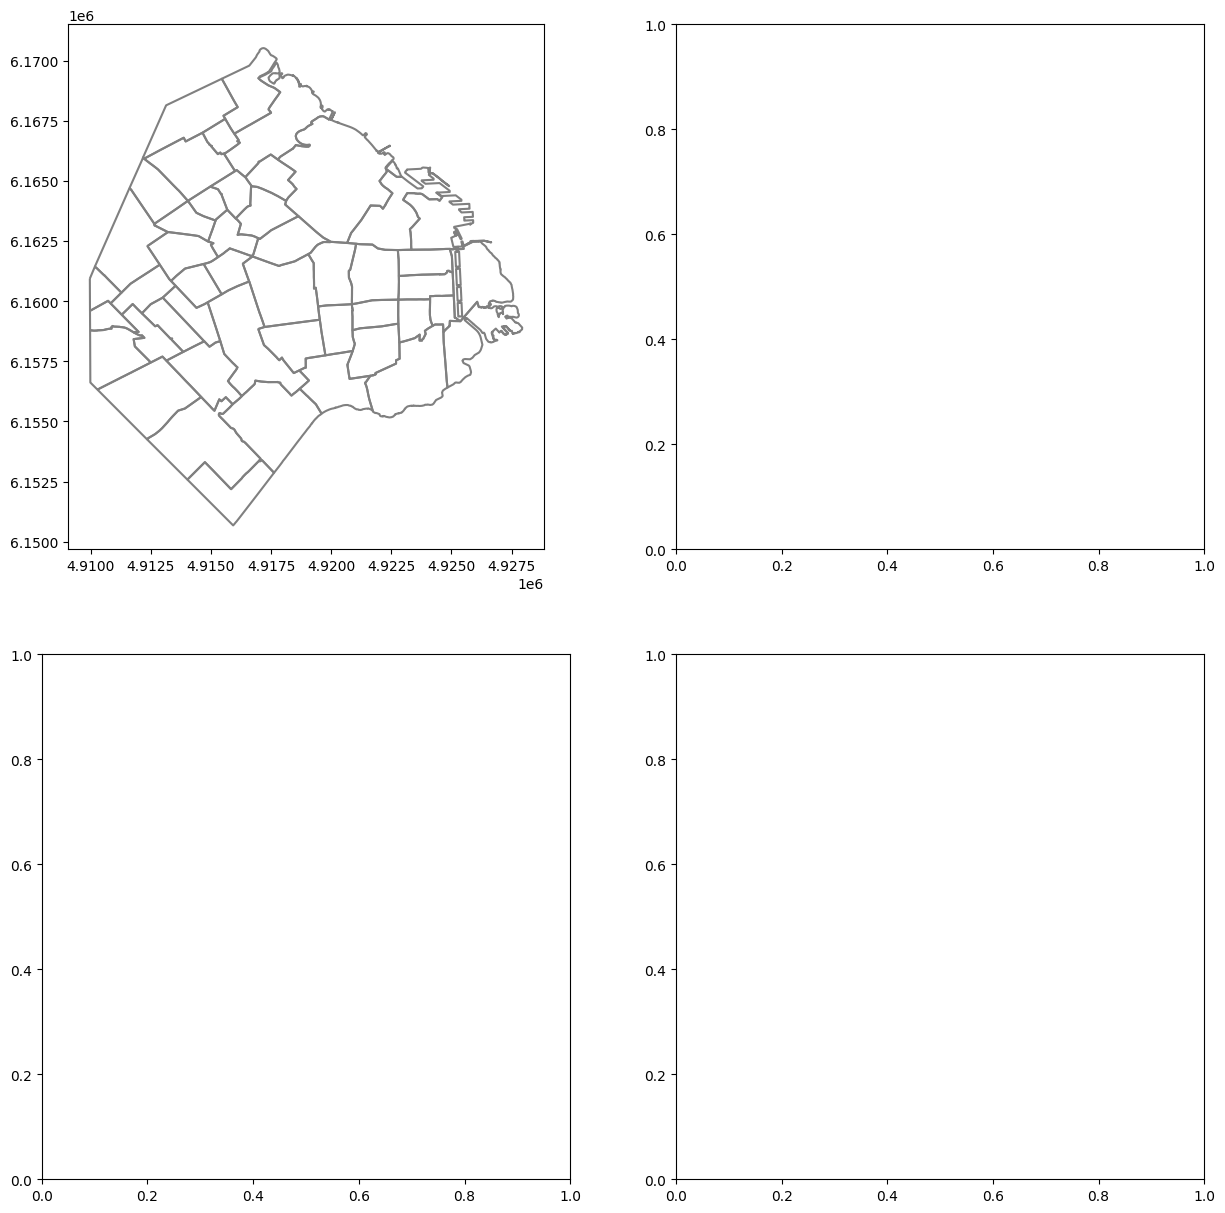

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten() 

alfa = 1/5
valores_m = [ 1, 3, 5, 10]
nodos_destacados = [134,104] # rojos
nodos_internos = [122,81] # verdes
for idx, m in enumerate(valores_m):
    A = construye_adyacencia(D,m)
    G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    p_rank = calcula_pagerank(A, alfa)
    ax = axs[idx]
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    indices_principales = graficar_red(p_rank, G, G_layout, Nprincipales=3,ax=ax)  # Le pasamos el subplot como argumento
    ax.set_title(f"Red de Museos - {m} links por nodo")
    print(f"\nMuseos mas relevantes con m = {m}\n")
    for idx_pp in indices_principales:
        print(f"Museo: {museos.name[idx_pp]}  |  nodo = {idx_pp}  |  page_rank = {np.round(p_rank[idx_pp],4)}")
        
plt.tight_layout()
plt.title(f"Red de Museos - {m} links por nodo")
plt.show()

m = 1
Cantidad de operaciones: 856800
Museo: Museo Nacional de Arte Decorativo  |  nodo = 34  |  page_rank = 0.0213
Museo: Museo del antiguo recinto del Congreso Nacional  |  nodo = 107  |  page_rank = 0.0217
Museo: Museo Nacional de Arte Oriental  |  nodo = 65  |  page_rank = 0.0221
m = 3
Cantidad de operaciones: 856800
Museo: Museo de la Ciudad  |  nodo = 18  |  page_rank = 0.0213
Museo: Museo de la Facultad de Odontología  |  nodo = 125  |  page_rank = 0.0235
Museo: Museo de Farmacobotánica  |  nodo = 117  |  page_rank = 0.0241
m = 5
Cantidad de operaciones: 856800
Museo: Museo de Farmacobotánica  |  nodo = 117  |  page_rank = 0.0211
Museo: Museo de la Facultad de Odontología  |  nodo = 125  |  page_rank = 0.0216
Museo: Museo de Odontología  |  nodo = 93  |  page_rank = 0.0217
m = 10
Cantidad de operaciones: 856800
Museo: Museo Casa Rosada  |  nodo = 15  |  page_rank = 0.0183
Museo: Museo Franciscano  |  nodo = 135  |  page_rank = 0.0183
Museo: Museo Histórico de la AFIP  |  nodo = 

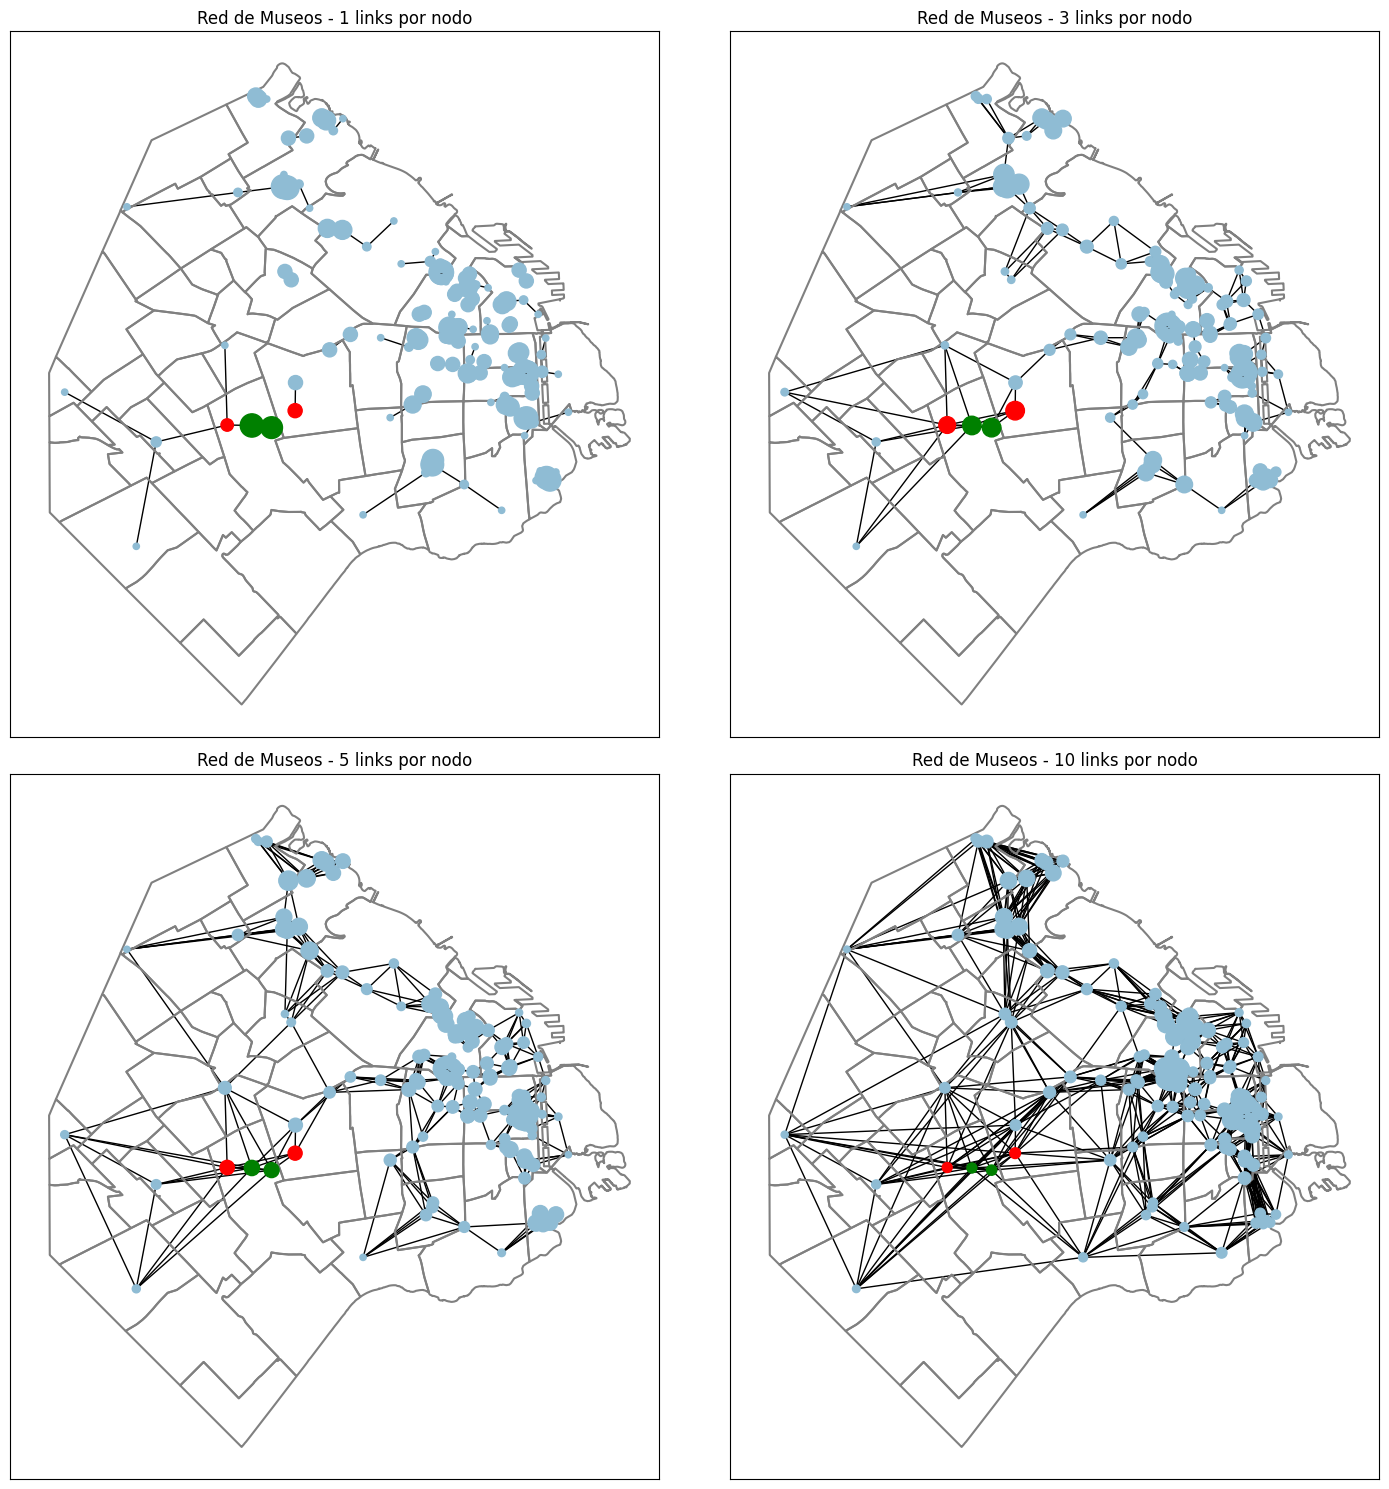

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten() 

alfa = 1/5
valores_m = [ 1, 3, 5, 10]
nodos_destacados = [134,104] # rojos
nodos_internos = [122,81] # verdes
for idx, m in enumerate(valores_m):
    print(f"m = {m}")
    A = construye_adyacencia(D,m)
    G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    p_rank = calcula_pagerank(A, alfa)
    ax = axs[idx]
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    indices_principales = graficar_red_periferia(p_rank, G, G_layout, Nprincipales=3,ax=ax,nodos_destacados= nodos_destacados,nodos_internos = nodos_internos)  # Le pasamos el subplot como argumento
    ax.set_title(f"Red de Museos - {m} links por nodo")
    for idx_pp in indices_principales:
        print(f"Museo: {museos.name[idx_pp]}  |  nodo = {idx_pp}  |  page_rank = {np.round(p_rank[idx_pp],4)}")
        
plt.tight_layout()
plt.title(f"Red de Museos - {m} links por nodo")
plt.show()


### Conclusión

Como se puede ver en los page ranks impresos en las figuras anteriores las posiciones no son estables ya que no hay una que se repita todos los graficos, es decir, ningun museo mantiene su ranking al variar m.

Un patron que se observa con pocas conexiones (m = 1) se puede ver en los nodos rojos [134,104] se mantienen con bajo page rank pero al tener 3 conexiones su page rank aumenta debido a que los nodos verdes [122,81] le aportaron puntaje ya que con 3 links se pudieron conectar. Tambien, veamos que cuando se tienen muchas conexiones sus valores se mantienen similares.Los nodos [122,81] (verdes) solamente son relevantes con una conexión. 

Finalmente, en el grupo del centro de la ciudad los nodos tienen, para pocas conexiones, puntajes variados entre altos y bajos, pero al obtener mas links algunos museos crecen en puntaje.  

Los barrios que obtienen mayor relevancia al aumentar los links son : San Telmo, Monserrat, San Nicolas, Recoleta, Nuñez y Belgrano, es decir la gran mayoria estan en lo que nosotros llamamos los museos centrales.

In [ ]:
#Dimensiones de A
N, M = A.shape  
#Inicializo la matriz identidad con las mismas dimensiones que A
Id = np.eye(N,M) 
# Defino un alfa
alfa = 1/5 
# Inicializo el vector b
b = np.ones(shape=(1,N)) 

# Calculo la matriz C
C = calcula_matriz_C(A)
# Armo la matriz M segun la formula deducida
M = N/alfa * (Id - (1-alfa)*C)
#Calculo la factorización LU de la matriz M para calcular su inversa
L, U = calculaLU(M)
print("Correcta descomposicion LU: ", np.allclose(M, L@U))
M_inv = calcular_inversa(L,U)
print("Correcto calculo de inversa: ", np.allclose(Id, M@M_inv))
p = M_inv @ b.T
print("El vector p es solucion de Mp=b: ", np.allclose(b.T, M@p))

p = calcula_pagerank(A, alfa)

Cantidad de operaciones: 856800
Correcta descomposicion LU:  True
Correcto calculo de inversa:  True
El vector p es solucion de Mp=b:  True
Cantidad de operaciones: 856800


#### Variando $ alpha $ 


α = 0.8571428571428571

Cantidad de operaciones: 856800
Top 5 inicial:
Museo: Museo del antiguo recinto del Congreso Nacional  | nodo = 107 | PR = 0.0087
Museo: Museo Franciscano  | nodo = 135 | PR = 0.0085
Museo: Museo de la Ciudad  | nodo = 18 | PR = 0.0085
Museo: Museo de Odontología  | nodo = 93 | PR = 0.0085
Museo: Museo de la Facultad de Odontología  | nodo = 125 | PR = 0.0085

α = 0.8

Cantidad de operaciones: 856800
Museo: Museo del antiguo recinto del Congreso Nacional  | nodo = 107 | PR = 0.0093
Museo: Museo Franciscano  | nodo = 135 | PR = 0.009
Museo: Museo de la Ciudad  | nodo = 18 | PR = 0.009
Museo: Museo de Odontología  | nodo = 93 | PR = 0.009
Museo: Museo de la Facultad de Odontología  | nodo = 125 | PR = 0.009

α = 0.6666666666666666

Cantidad de operaciones: 856800
Museo: Museo del antiguo recinto del Congreso Nacional  | nodo = 107 | PR = 0.0107
Museo: Museo Franciscano  | nodo = 135 | PR = 0.0104
Museo: Museo de la Ciudad  | nodo = 18 | PR = 0.0104
Museo: Museo d

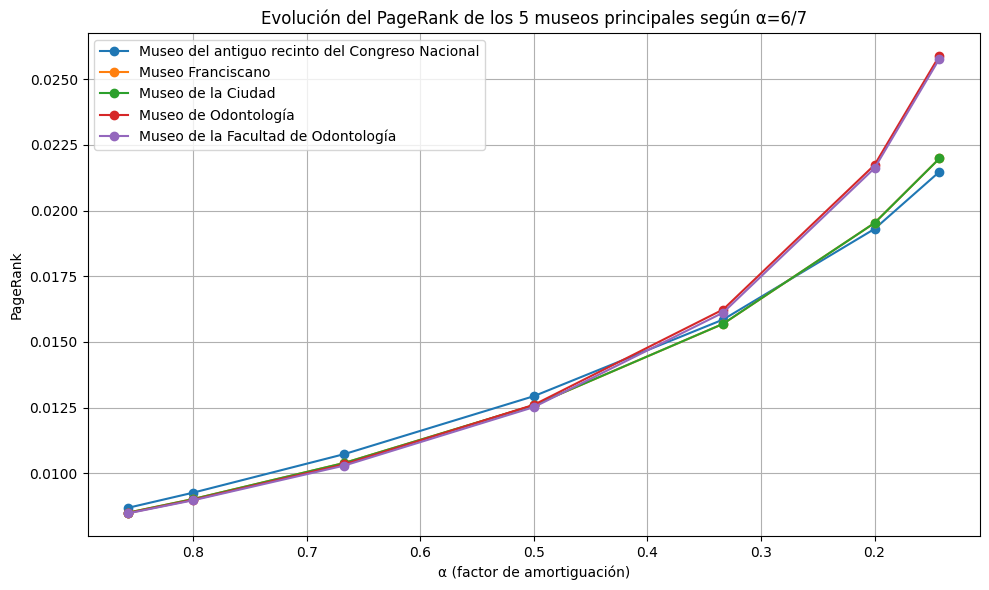

In [ ]:
m = 5
A = construye_adyacencia(D, m)
G = nx.from_numpy_array(A)
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]

ranking_evol = {}         # idx museo -> lista de PR
top5_indices = []         # top 5 del primer alpha

for i, alfa in enumerate(alphas):
    print(f"\nα = {alfa}\n")
    p_rank = calcula_pagerank(A, alfa)

    if i == 0:
        # Tomamos los top 5 del primer alfa y los inicializamos
        top5_indices = np.argsort(p_rank)[-5:][::-1]
        print("Top 5 inicial:")
        for idx_m in top5_indices:
            print(f"Museo: {museos.name[idx_m]}  | nodo = {idx_m} | PR = {np.round(p_rank[idx_m], 4)}")
            ranking_evol[idx_m] = [p_rank[idx_m]]
    else:
        # Guardamos PR para los mismos museos del top 5 inicial
        for idx_m in top5_indices:
            ranking_evol[idx_m].append(p_rank[idx_m])
            print(f"Museo: {museos.name[idx_m]}  | nodo = {idx_m} | PR = {np.round(p_rank[idx_m], 4)}")

# Plot
plt.figure(figsize=(10, 6))
for idx in top5_indices:
    plt.plot(alphas, ranking_evol[idx], marker='o', label=museos.name[idx])

plt.xlabel("α (factor de amortiguación)")
plt.ylabel("PageRank")
plt.title("Evolución del PageRank de los 5 museos principales según α=6/7")
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()


alfa = 0.8571428571428571

Cantidad de operaciones: 856800
Museo: Museo de la Ciudad  |  nodo = 18  |  page_rank = 0.0085
Museo: Museo Franciscano  |  nodo = 135  |  page_rank = 0.0085
Museo: Museo del antiguo recinto del Congreso Nacional  |  nodo = 107  |  page_rank = 0.0087

alfa = 0.8

Cantidad de operaciones: 856800
Museo: Museo de la Ciudad  |  nodo = 18  |  page_rank = 0.009
Museo: Museo Franciscano  |  nodo = 135  |  page_rank = 0.009
Museo: Museo del antiguo recinto del Congreso Nacional  |  nodo = 107  |  page_rank = 0.0093

alfa = 0.6666666666666666

Cantidad de operaciones: 856800
Museo: Museo Franciscano  |  nodo = 135  |  page_rank = 0.0104
Museo: Museo de la Ciudad  |  nodo = 18  |  page_rank = 0.0104
Museo: Museo del antiguo recinto del Congreso Nacional  |  nodo = 107  |  page_rank = 0.0107

alfa = 0.5

Cantidad de operaciones: 856800
Museo: Museo Franciscano  |  nodo = 135  |  page_rank = 0.0126
Museo: Museo de Odontología  |  nodo = 93  |  page_rank = 0.0126
Museo: 

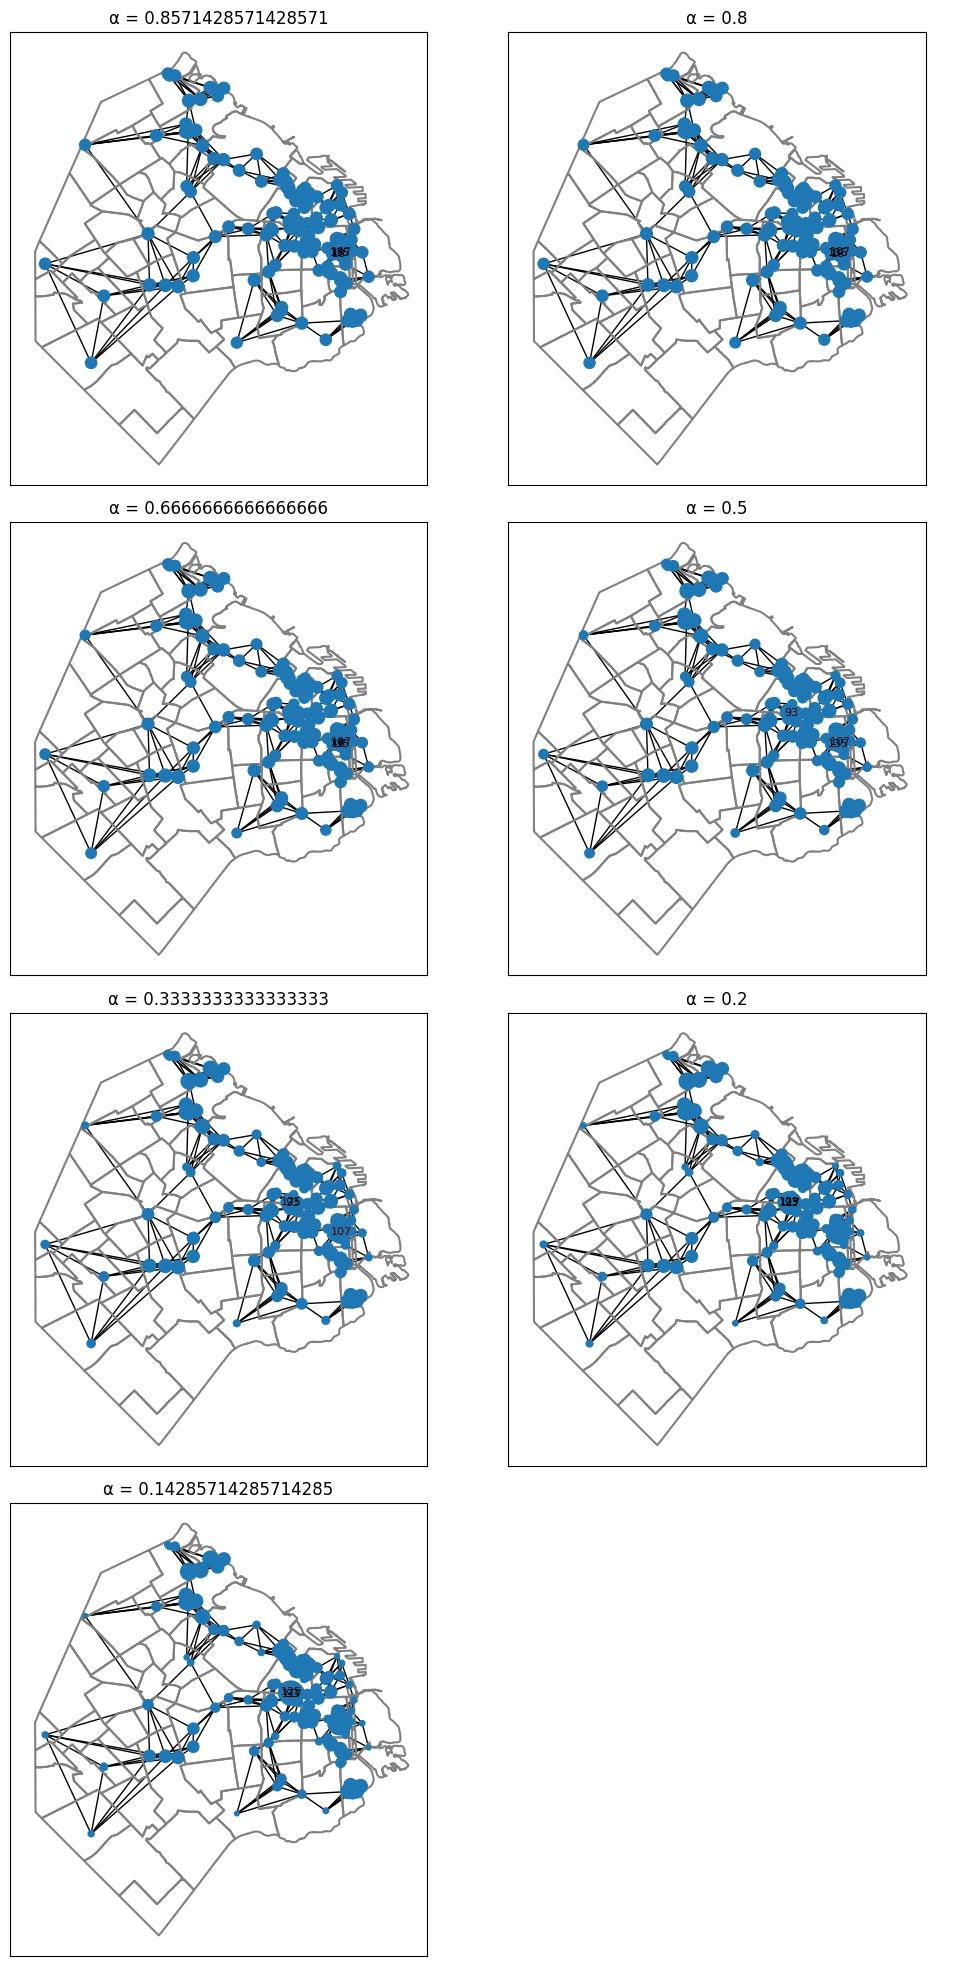

In [ ]:
m = 5
A = construye_adyacencia(D,m)
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.flatten() 

for idx,alfa in enumerate([ 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]):
    ax = axs[idx]
    print(f"\nalfa = {alfa}\n")
    p_rank = calcula_pagerank(A, alfa)
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    ax = axs[idx]
    axs[idx].set_title(f"α = {alfa}")
    indices_principales = graficar_red(p_rank, G, G_layout, Nprincipales=3,ax=ax,color=False) # Graficamos la red con el Page Rank
    for idx,idx_pp in enumerate(indices_principales):
        print(f"Museo: {museos.name[idx_pp]}  |  nodo = {idx_pp}  |  page_rank = {np.round(p_rank[idx_pp],4)}")
    plt.tight_layout()

axs[-1].axis('off')
plt.show()

Como se puede ver en los page ranks impresos y en las figuras anteriores las posiciones no son estables en todos los alfas, pero si museos como el 107 y 93 se mentienen estables en la mayoria de los alfas. 

Cantidad de operaciones: 856800
Para alfa = 0.8571428571428571
Museo: Museo Criollo de los Corrales  |  nodo = 60  |  page_rank = 0.0067
Museo: Museo del Automóvil  |  nodo = 37  |  page_rank = 0.0067
Museo: Museo Histórico de Buenos Aires Cornelio de Saavedra  |  nodo = 26  |  page_rank = 0.0063
Museo: Museo Manoblanca  |  nodo = 127  |  page_rank = 0.0063
Museo: Museo de la Balanza  |  nodo = 102  |  page_rank = 0.0065
Museo: Museo archivo tecno educativo Lorenzo Raggio  |  nodo = 77  |  page_rank = 0.0067
Cantidad de operaciones: 856800
Para alfa = 0.14285714285714285
Museo: Museo Criollo de los Corrales  |  nodo = 60  |  page_rank = 0.0019
Museo: Museo del Automóvil  |  nodo = 37  |  page_rank = 0.0019
Museo: Museo Histórico de Buenos Aires Cornelio de Saavedra  |  nodo = 26  |  page_rank = 0.0011
Museo: Museo Manoblanca  |  nodo = 127  |  page_rank = 0.0011
Museo: Museo de la Balanza  |  nodo = 102  |  page_rank = 0.0017
Museo: Museo archivo tecno educativo Lorenzo Raggio  |  nodo

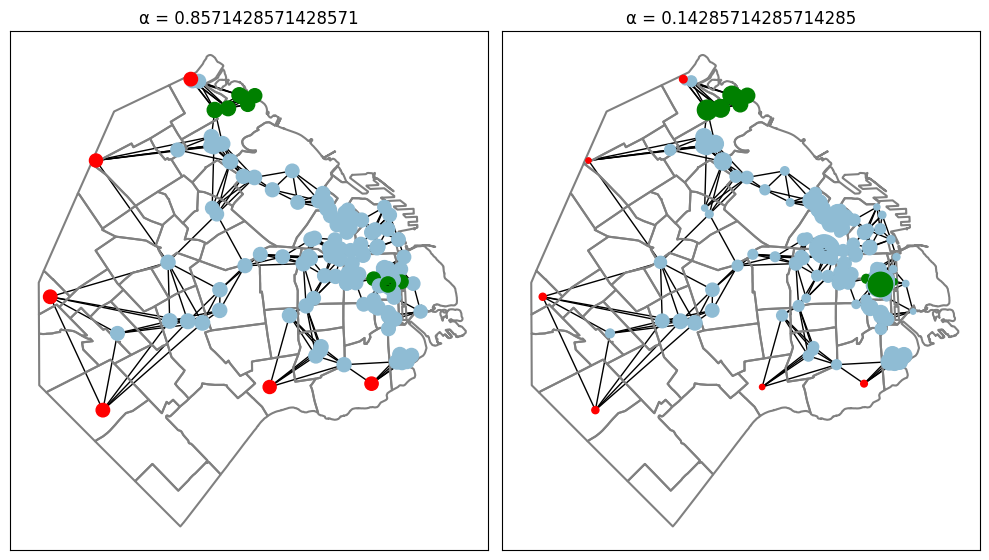

In [ ]:
m = 5
A = construye_adyacencia(D,m)
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
fig, axs = plt.subplots(1, 2, figsize=(10, 20))
axs = axs.flatten() 
nodos_destacados = [60, 37, 26, 127, 102, 77]
nodos_internos = [113,8,79,80,30,84,59,14,135]

for idx,alfa in enumerate([ 6/7, 1/7]):
    ax = axs[idx]
    p_rank = calcula_pagerank(A, alfa)
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    ax = axs[idx]
    axs[idx].set_title(f"α = {alfa}")
    print(f"Para alfa = {alfa}")
    for nodo_p in nodos_destacados:
        print(f"Museo: {museos.name[nodo_p]}  |  nodo = {nodo_p}  |  page_rank = {np.round(p_rank[nodo_p], 4)}")
    graficar_red_periferia(p_rank, G, G_layout, nodos_destacados=nodos_destacados, nodos_internos=nodos_internos, Nprincipales=3, ax=ax) # Graficamos la red con el Page Rank
    plt.tight_layout()

plt.show()

## Conclusión 

Simplificando el grafico anterior solamente utilizando el $\alpha$ mas grande y al mas chico. 

Concluimos que a mayor $\alpha$ aquellos museos que tienen conexiones menos importantes (En nuestro ejemplo los mas perifericos, en color rojo) obtienen un page rank mas alto, pero a medida que decrece el $\alpha$ sus posiciones en el page rank van decayendo. Esto es porque el $\alpha$ representa la probabilidad de ir a un museo que no tenga conexión con el actual. Esto evidencia otro patron que ocurre en los nodos que tienen muchos museos cercanos como aquellos ubicados en el centro de la ciudad en nuestro ejemplo en color verde, esto ocurre porque el factor de amortiguamiento es bajo, es decir, la mayor concentración de gente se mantiene en la cercanias.

Tambien de las imagenes se concluye que si $\alpha$ se acerca a 1 hace que el page rank de los museos se mantenga uniforme. 

## Punto 4:

**v** = total de visitantes como punto de entrada en cada museo

**w** = total de visitantes recibidos en cada museo

$B = \sum_{k=0}^{r-1} C^{k}$

Queremos ver que $ v = B^{-1}w $

$C^{k}v \rightarrow$ numero esperado de visitantes en cada museo luego de $k$ iteraciones

Se puede ver que:

$$
\begin{cases}
k=0  && C^{0}v = Iv = v && \rightarrow \text{visitantes iniciales} \\
k=1 && C^{1}v = Cv && \rightarrow \text{visitantes luego de la primera iteración} \\
k=2 && C^{2}v && \rightarrow \text{visitantes luego de la segunda iteración} \\
\vdots && \vdots && \vdots \\
k=r-1 && C^{r-1} && \rightarrow \text{visitantes luego de r-1 iteraciones}
\end{cases}
$$

La suma de todas las instancias es igual a la cantidad de visitantes totales recibidas en cada museo

$$
\begin{align*}
C^{0}v + C^{1}v+ C^{2}v + \dots + C^{r-1}v &&= w \\
\underbrace{\sum_{k=0}^{r-1} C^{k}}_{B}v &&= w  \\
Bv &&= w \\
\end{align*}
$$
Asumo B inversible 
$$
v = B^{-1}w
$$



## Punto 5:

In [ ]:
#Importo el archivo 
w = np.loadtxt("visitas.txt")

print("Cantidad final: ", np.linalg.norm(w,1))

Cantidad final:  409815.0


In [ ]:
r = 3 # Defino el numero de pasos
C = calcula_matriz_C_continua(D) # Calculo la matriz de transiciones
B = calcula_B(C, r) # Calculo la matriz B
print(B)
v = resolver_sistema(B,w)

print("Cantidad de primeras visitas: ", np.linalg.norm(v,1)) # Calculo la cantidad de visitantes

NameError: name 'D' is not defined

/home/agus/UBA/TP1-alc-2025-1c/.venv/lib64/python3.11/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


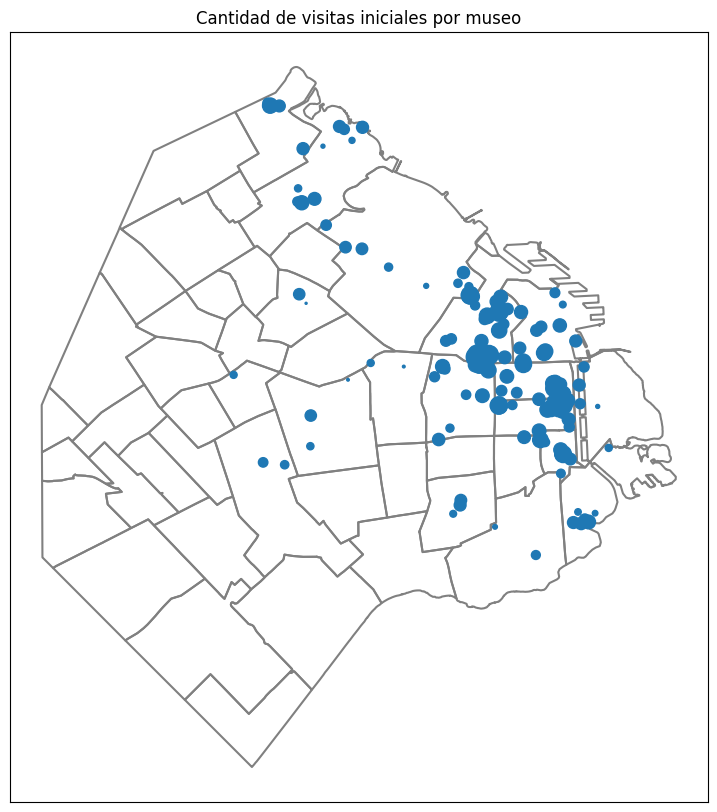

In [ ]:
graficar_nodos(v, G, G_layout, barrios)
plt.show()

## Punto 6:

In [2]:
B = calcula_B(C, r)
print(B)
LU = calculaLU(B)
B_inv = calcular_inversa(L,U)

B_cond = np.linalg.norm(B,1) * np.linalg.norm(B_inv,1) # Calculo el numero de condicion de B
w_delta_norm = 0.05 # Defino el delta de w
 
print("Número de condición 1 de B: ", B_cond)
print("Cota para el error de estimación de v: ", B_cond * w_delta_norm)

NameError: name 'C' is not defined

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

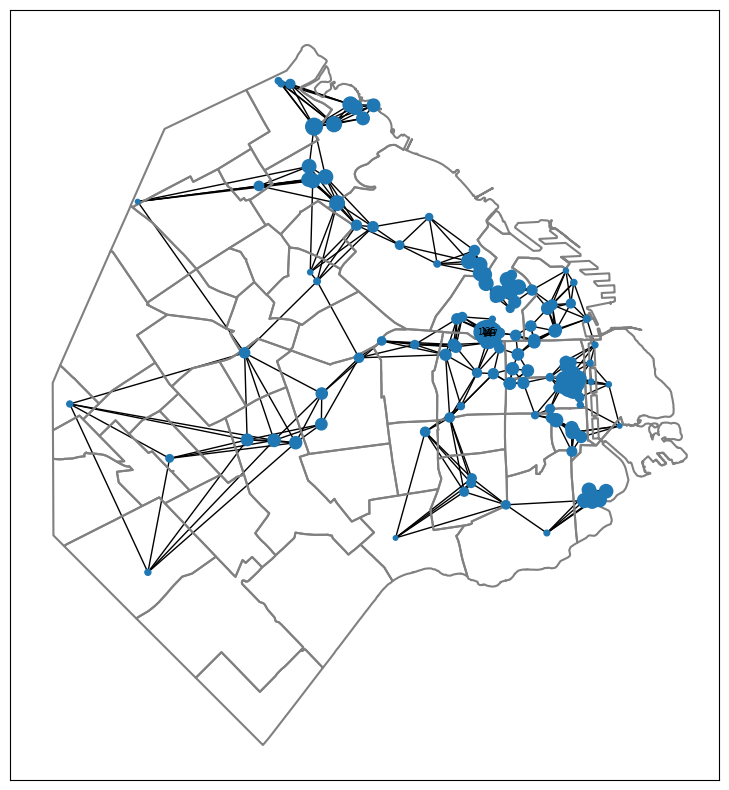

In [18]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = p_rank #np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres